# Import Libraries

In [ ]:
from datasets import Dataset
from functools import partial
from itertools import combinations
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,cohen_kappa_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## TEXT FUNCTIONS

In [ ]:
# Registry of supported Hugging Face models used in the project.
# Add new models here to enable them across the pipeline.

MODEL_REGISTRY = {
    "text": {
        "bert_italian_cased": "dbmdz/bert-base-italian-cased",
        "beto_spanish_uncased": "dccuchile/bert-base-spanish-wwm-uncased",
    },
    "audio": {
        "hubert_base": "facebook/hubert-base-ls960",
        "wav2vec2_base": "facebook/wav2vec2-base-960h",
    }
}

In [ ]:
# You can add more model from hugging face
paths = {
    'bert_italian': 'dbmdz/bert-base-italian-cased'
}

# Dataset Preprocessing and Preparation

In [ ]:
def prepare_dataloaders(dataframes, tokenizer, batch_size=128, max_length=76, num_workers=4, shuffle_train=True, label_column='label'):

    """
    Prepares Hugging Face Datasets and PyTorch DataLoaders for train/val/test splits.

    Args:
        dataframes (dict): Dictionary with keys 'train', 'val', and 'test', each containing the corresponding DataFrame.
        tokenizer: Hugging Face tokenizer used to encode the text inputs.
        batch_size (int): Batch size for the DataLoaders.
        max_length (int): Maximum sequence length for tokenization.
                          (76 was chosen because it corresponds to the maximum text length in the dataset.)
        num_workers (int): Number of worker threads used by the DataLoaders.
        shuffle_train (bool): Whether to shuffle the training DataLoader.
        label_column (str): Name of the column containing the labels in the DataFrames.

    Returns:
        datasets (dict): Dictionary containing the tokenized Hugging Face Datasets.
        dataloaders (dict): Dictionary containing the corresponding PyTorch DataLoaders.
    """

    def tokenize_dataframe(df):
        df = df[['transcription', label_column]].copy()
        dataset = Dataset.from_pandas(df)

        def tokenize(batch):
            return tokenizer(
                batch['transcription'],
                padding='max_length',
                truncation=True,
                max_length=max_length
            )

        dataset = dataset.map(tokenize, batched=True, batch_size=len(dataset))
        dataset.set_format('torch', columns=['input_ids', 'attention_mask', label_column], output_all_columns=False)
        dataset = dataset.rename_column(label_column, 'labels')
        return dataset

    datasets = {key: tokenize_dataframe(df) for key, df in dataframes.items()}

    dataloaders = {}
    for key, ds in datasets.items():
        shuffle_flag = shuffle_train if key == 'train' else False
        dataloaders[key] = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=shuffle_flag,
            num_workers=num_workers,
            pin_memory=True
        )

    return datasets, dataloaders

# Training's function

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "eval_f1": f1}

In [ ]:
def train_hf_model(model, datasets, output_dir='./results',
                   num_labels=2, train_batch_size=16, eval_batch_size=32,
                   num_train_epochs=3, learning_rate=2e-5,
                   eval_strategy="epoch", save_strategy="epoch",
                   metric_for_best_model="eval_f1", greater_is_better=True,
                   early_stopping_patience=3, compute_metrics=compute_metrics):

    """
    Generic function for training a Hugging Face model using the Trainer API.

    Args:
        model: Hugging Face model (e.g., AutoModelForSequenceClassification).
        datasets (dict): Dictionary containing Hugging Face Datasets with keys 'train', 'val' (and optionally 'test').
        output_dir (str): Directory where checkpoints and output files will be saved.
        num_labels (int): Number of target classes.
        train_batch_size (int): Batch size used during training.
        eval_batch_size (int): Batch size used during evaluation.
        num_train_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        eval_strategy (str): Evaluation strategy ("steps" or "epoch").
        save_strategy (str): Checkpoint saving strategy ("steps" or "epoch").
        metric_for_best_model (str): Metric used to select the best model.
        greater_is_better (bool): Whether a higher value of the selected metric indicates a better model.
        early_stopping_patience (int): Number of evaluation steps or epochs to wait before early stopping.
        compute_metrics (callable): Function used to compute evaluation metrics.

    Returns:
        trainer: Trained Hugging Face Trainer instance.
        eval_results: Dictionary containing evaluation results.
    """


    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        eval_strategy=eval_strategy,
        save_strategy=save_strategy,
        load_best_model_at_end=True,
        metric_for_best_model=metric_for_best_model,
        greater_is_better=greater_is_better,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=datasets['train'],
        eval_dataset=datasets['val'],
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)]
    )

    # Start training
    trainer.train()
    eval_results = trainer.evaluate()

    print(f" Training completed successfully!")
    print(f" Evaluation results: {eval_results}")

    return trainer, eval_results

# Test's function

In [ ]:
def test_model(model, dataset_test, class_names=None, batch_size=32, average='macro'):

    """
    Runs model inference on the test dataset and computes evaluation metrics.
    Returns a dictionary containing metrics, predictions, and additional information.

    Args:
        model: Trained PyTorch model.
        dataset_test: PyTorch Dataset that must return 'input_ids', 'attention_mask', and 'labels'.
        class_names (list): List of class names (e.g., ['No Satire', 'Satire']).
        batch_size (int): Batch size used for the DataLoader.
        average (str): Averaging method for F1/Precision/Recall ('macro', 'weighted', etc.).

    Returns:
        results (dict): Dictionary containing metrics, confusion matrix, predictions, and per-class information.
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, drop_last=False)

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader_test:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    all_logits = torch.cat(all_logits, dim=0)
    true_labels = torch.cat(all_labels, dim=0).numpy()

    probabilities = F.softmax(all_logits, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1).numpy()

    # Metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average=average)
    precision = precision_score(true_labels, predicted_labels, average=average)
    recall = recall_score(true_labels, predicted_labels, average=average)
    kappa = cohen_kappa_score(true_labels, predicted_labels)

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Number of istances fro classes
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    num_per_class = dict(zip(class_names, np.sum(cm, axis=1)))

    # Stampa
    print("\n=== Test Results ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score ({average}): {f1:.4f}")
    print(f"Precision ({average}): {precision:.4f}")
    print(f"Recall ({average}): {recall:.4f}")
    print(f"Cohen Kappa: {kappa:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    results = {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "cohen_kappa": kappa,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
        "probabilities": probabilities.numpy(),
        "confusion_matrix": cm,
        "num_per_class": num_per_class,
        "class_names": class_names
    }

    return results

# Save Results

In [ ]:
def save_test_results(test_results, save_path):

"""
Saves test results to a JSON file and numerical arrays to .npy files.
Automatically handles non-serializable NumPy data types.
"""

    os.makedirs(save_path, exist_ok=True)

    # Chiavi da salvare separatamente come .npy
    array_keys = [
        'true_labels',
        'predicted_labels',
        'probabilities',
        'confusion_matrix',
        'num_per_class'
    ]

    # Funzione per rendere serializzabili i valori
    def make_serializable(obj):
        if isinstance(obj, (np.integer, np.int32, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (set, tuple)):
            return list(obj)
        else:
            return obj

    # Salva tutto tranne gli array grandi in JSON
    json_results = {k: make_serializable(v) for k, v in test_results.items() if k not in array_keys}

    json_file = os.path.join(save_path, 'test_results.json')
    with open(json_file, 'w') as f:
        json.dump(json_results, f, indent=4)

    # Salva gli array grandi in file .npy
    for key in array_keys:
        if key in test_results:
            np.save(os.path.join(save_path, f"{key}.npy"), test_results[key])

    print(f"Results saved in: {save_path}")

# Main

In [ ]:
torch.cuda.empty_cache()


=== Processing Cross 5 ===
id2label: {0: 'no_satire;', 1: 'satire;'}
label2id: {'no_satire;': 0, 'satire;': 1}


Map:   0%|          | 0/6370 [00:00<?, ? examples/s]

Map:   0%|          | 0/1125 [00:00<?, ? examples/s]

Map:   0%|          | 0/2571 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.300147,0.876795,0.877333
2,0.363400,0.312831,0.889650,0.889778
3,0.195400,0.402355,0.882658,0.882667


 Training completed successfully!
 Evaluation results: {'eval_f1': 0.8896502671359481, 'eval_loss': 0.31283074617385864, 'eval_accuracy': 0.8897777777777778, 'eval_runtime': 4.8016, 'eval_samples_per_second': 234.296, 'eval_steps_per_second': 7.497, 'epoch': 3.0}

--- Test Cross 5 ---

=== Test Results ===
Accuracy:  0.8036
F1 Score (macro): 0.8008
Precision (macro): 0.8208
Recall (macro): 0.8032
Cohen Kappa: 0.6068

Classification Report:
              precision    recall  f1-score   support

  no_satire;       0.89      0.69      0.78      1281
     satire;       0.75      0.92      0.82      1290

    accuracy                           0.80      2571
   macro avg       0.82      0.80      0.80      2571
weighted avg       0.82      0.80      0.80      2571



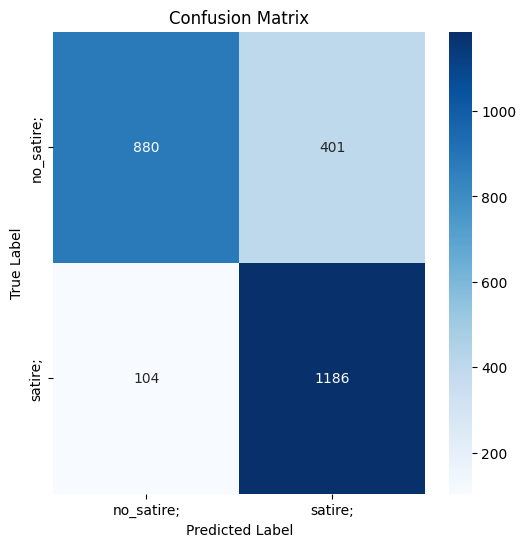

In [ ]:
# Global variables
base_path = '/content/drive/My Drive/Colab Notebooks/Tirocinio_italiano/Cross Validation'
base_save_path = '/content/drive/My Drive/Colab Notebooks/Tirocinio_italiano/Text Training/Base'
num_splits = 10
batch_size = 128
model_name = 'dbmdz/bert-base-italian-cased'
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)

# ===== Loop su tutti gli split =====
for i in range(5, 6):
    print(f"\n=== Processing Cross {i} ===")
    split_path = os.path.join(base_path, f'Cross {i}')

    # File CSV
    train_file = os.path.join(split_path, 'train.csv')
    val_file = os.path.join(split_path, 'validation.csv')
    test_file = os.path.join(split_path, 'test.csv')

    # Leggi i CSV
    df_train = pd.read_csv(train_file)
    df_val = pd.read_csv(val_file)
    df_test = pd.read_csv(test_file)

    # Label mapping
    labels = sorted(df_train['label'].unique().tolist())
    id2label = {id: label for id, label in enumerate(labels)}
    label2id = {label: id for id, label in enumerate(labels)}
    print("id2label:", id2label)
    print("label2id:", label2id)

    # Mappa le etichette nei DataFrame
    df_train['label'] = df_train['label'].map(label2id)
    df_val['label'] = df_val['label'].map(label2id)
    df_test['label'] = df_test['label'].map(label2id)

    # Prepara dataset e dataloader
    dataframes = {'train': df_train, 'val': df_val, 'test': df_test}
    datasets, dataloaders = prepare_dataloaders(dataframes, tokenizer, batch_size=batch_size)

    # Crea modello
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )

    # Addestramento
    output_dir = os.path.join(base_save_path, f'Cross {i}')
    trainer, eval_results = train_hf_model(
        model=model,
        datasets=datasets,
        output_dir=output_dir,
        num_labels=num_labels
    )

    # Test
    print(f"\n--- Test Cross {i} ---")
    test_results = test_model(
        model=model,
        dataset_test=datasets['test'],
        class_names=labels,
        batch_size=32
    )

    # ===== Salvataggio dei risultati =====
    #save_path = os.path.join(base_save_path, f'Cross {i}')
    #save_test_results(test_results, save_path)

# Last Validation with 2k examples

In [ ]:
# ===== Parametri generali =====
base_path = '/content/drive/My Drive/Colab Notebooks/Tirocinio_italiano/Cross Validation'
base_save_path = '/content/drive/My Drive/Colab Notebooks/Tirocinio_italiano/Text Training/Base'
num_splits = 10
batch_size = 128
model_name = 'dbmdz/bert-base-italian-cased'
num_labels = 2
i=1

tokenizer = AutoTokenizer.from_pretrained(model_name)


print(f"\n=== Processing ===")
split_path = os.path.join(base_path, f'Cross {i}')

# File CSV
train_file = os.path.join(split_path, 'train.csv')
val_file = os.path.join(split_path, 'validation.csv')
test_file = os.path.join(split_path, 'test.csv')

# Leggi i CSV
df_train = pd.read_csv(train_file)
df_val = pd.read_csv(val_file)
df_test = pd.read_csv(test_file)

# Label mapping
labels = sorted(df_train['label'].unique().tolist())
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}
print("id2label:", id2label)
print("label2id:", label2id)

# Mappa le etichette nei DataFrame
df_train['label'] = df_train['label'].map(label2id)
df_val['label'] = df_val['label'].map(label2id)
df_test['label'] = df_test['label'].map(label2id)

df_all= pd.concat([df_train, df_val, df_test])
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)

df_train, df_val = train_test_split(df_all, test_size=0.2, random_state=42)

# Prepara dataset e dataloader
dataframes = {'train': df_train, 'val': df_val}
datasets, dataloaders = prepare_dataloaders(dataframes, tokenizer, batch_size=batch_size)

# Crea modello
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Addestramento
output_dir = os.path.join(base_save_path, f'Cross {i}')
trainer, eval_results = train_hf_model(
        model=model,
        datasets=datasets,
        output_dir=output_dir,
        num_labels=num_labels
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]


=== Processing ===
id2label: {0: 'no_satire;', 1: 'satire;'}
label2id: {'no_satire;': 0, 'satire;': 1}


Map:   0%|          | 0/8044 [00:00<?, ? examples/s]

Map:   0%|          | 0/2012 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: marco03-bortolotti (marco03-bortolotti-universit-degli-studi-di-ferrara) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.411400,0.307547,0.880718,0.880716
2,0.252900,0.310071,0.891012,0.891153
3,0.161100,0.373092,0.885191,0.885189


 Training completed successfully!
 Evaluation results: {'eval_f1': 0.8910122439402345, 'eval_loss': 0.3100706934928894, 'eval_accuracy': 0.8911530815109344, 'eval_runtime': 9.3034, 'eval_samples_per_second': 216.265, 'eval_steps_per_second': 6.772, 'epoch': 3.0}


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- Test datasert external

=== Test Results ===
Accuracy:  0.8960
F1 Score (macro): 0.8959
Precision (macro): 0.8977
Recall (macro): 0.8960
Cohen Kappa: 0.7920

Classification Report:
              precision    recall  f1-score   support

  no_satire;       0.92      0.86      0.89      1000
     satire;       0.87      0.93      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



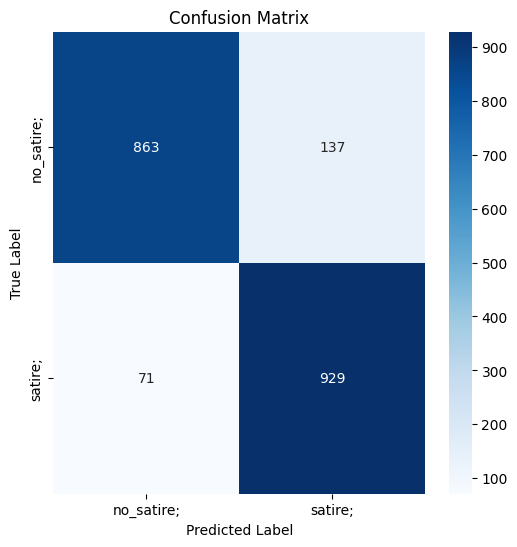

Results saved in: /content/drive/My Drive/Colab Notebooks/Tirocinio_italiano/Text Training/Base/Dataset_Esterno_Results/Cross 1


In [ ]:
dataset_esterno_path ='/content/drive/My Drive/Colab Notebooks/Tirocinio_italiano/Cross Validation'
base_save_path = '/content/drive/My Drive/Colab Notebooks/Tirocinio_italiano/Text Training/Base/Dataset_Esterno_Results'
# File CSV
external_file= os.path.join( dataset_esterno_path, 'dataset_2k.csv')

df_external = pd.read_csv(external_file)

 # Mappa le etichette nei DataFrame
df_external['label'] = df_external['label'].map(label2id)

# Prepara dataset e dataloader
dataframes = {'external': df_external}
datasets, dataloaders = prepare_dataloaders(dataframes, tokenizer, batch_size=batch_size)

# Test
print(f"\n--- Test datasert external")
test_results = test_model(
        model=model,
        dataset_test=datasets['external'],
        class_names=labels,
        batch_size=32
    )

# ===== Salvataggio dei risultati =====
save_path = os.path.join(base_save_path, f'Cross {i}')
save_test_results(test_results, save_path)

# Anlzisis of number of token in the istances for tha padding

Lunghezza minima: 28
Lunghezza massima: 92
Lunghezza media: 48.98
95° percentile: 66.0
99° percentile: 75.0


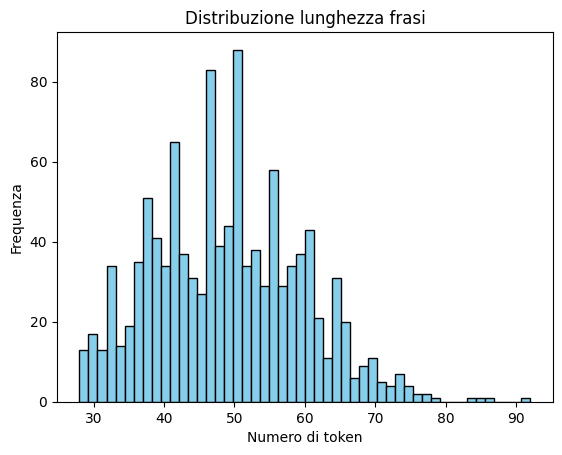

In [ ]:
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Supponiamo tu abbia un DataFrame df con la colonna 'transcription'
tokenizer = AutoTokenizer.from_pretrained('dbmdz/bert-base-italian-cased')

# Tokenizza tutte le frasi senza padding/truncation
lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in df_val['transcription']]

# Statistiche di base
lengths = np.array(lengths)
print(f"Lunghezza minima: {lengths.min()}")
print(f"Lunghezza massima: {lengths.max()}")
print(f"Lunghezza media: {lengths.mean():.2f}")
print(f"95° percentile: {np.percentile(lengths, 95)}")
print(f"99° percentile: {np.percentile(lengths, 99)}")

# Istogramma delle lunghezze
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Numero di token")
plt.ylabel("Frequenza")
plt.title("Distribuzione lunghezza frasi")
plt.show()


Solo lunghezza frasi

=== STATISTICHE GLOBALI (train + val + test) ===
Min parole: 23
Max parole: 48
Media parole: 35.24
95° percentile: 47.0
99° percentile: 48.0


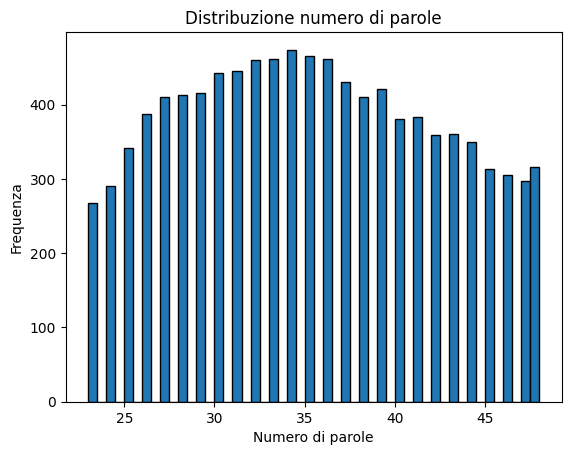

In [ ]:
# Unisci i tre DataFrame
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Conteggio parole (split su spazi)
word_lengths = [len(str(text).split()) for text in df_all['transcription']]

word_lengths = np.array(word_lengths)

print("=== STATISTICHE GLOBALI (train + val + test) ===")
print(f"Min parole: {word_lengths.min()}")
print(f"Max parole: {word_lengths.max()}")
print(f"Media parole: {word_lengths.mean():.2f}")
print(f"95° percentile: {np.percentile(word_lengths, 95)}")
print(f"99° percentile: {np.percentile(word_lengths, 99)}")

plt.hist(word_lengths, bins=50, edgecolor='black')
plt.xlabel("Numero di parole")
plt.ylabel("Frequenza")
plt.title("Distribuzione numero di parole")
plt.show()


# Controllo uguaglianza dataset training e esterno

In [ ]:
df_all["transcription_norm"] = df_all["transcription"].str.strip().str.lower()
df_external["transcription_norm"] = df_external["transcription"].str.strip().str.lower()


In [ ]:
overlap = set(df_all["transcription_norm"]).intersection(
    set(df_external["transcription_norm"])
)


In [ ]:
print(f"Numero di trascrizioni duplicate tra i due dataset: {len(overlap)}")

if len(overlap) > 0:
    print("\nEsempi di duplicati:")
    for t in list(overlap)[:10]:   # primi 10
        print("-", t)


Numero di trascrizioni duplicate tra i due dataset: 0
